In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np

import fastai as meta_fai
import fastai.vision as fv
import fastai.basics as fai
import fastai.fastai_audio as fa

from pathlib import Path
from IPython.display import Audio

In [3]:
path_good   = Path("Clean_norm/")
path_crappy = Path("Noise_norm/")
path        = Path("../models/")

In [4]:
def file_name(path:Path):
    file_name = path.relative_to(path_crappy)
    file_name = path_good/file_name
    return file_name.with_suffix(".wav")

In [5]:
def load_data(batch_size, amount=1., n_fft=2046, n_hop=512):
    tfms = fa.get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop, decibels=False, mult_padding=16)
    data = (fa.AudioAudioList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .split_by_rand_pct(0.2)
            .label_from_func(file_name)
            .databunch(bs=batch_size, tfms=tfms))
    return data

In [6]:
data = load_data(8, amount=1.)

data.show_batch(3);

In [7]:
def l1_loss_flat(a,b):
    return F.mse_loss(10*a.squeeze(), 10*b.squeeze())

In [8]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, 
                           blur=False, norm_type=fai.NormType.Weight, 
                           self_attention=True, y_range=(-3.,3.), 
                           loss_func=l1_loss_flat, wd=1e-2)

In [9]:
learn = create_learner(data)

In [10]:
learn.model_dir = path

In [11]:
learn.model[0][0]     = nn.Sequential(nn.Conv2d(2,  64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
learn.model[10][0][0] = nn.Sequential(nn.Conv2d(98, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
learn.model[10][1][0] = nn.Sequential(nn.Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
learn.model[11][0]    = nn.Sequential(nn.Conv2d(98, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#learn.model[12]       = nn.Sequential(nn.Conv2d(99, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [12]:
learn.model.cuda(0);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


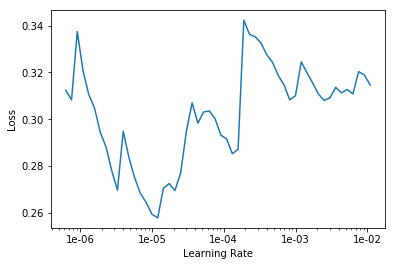

In [15]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 7e-6)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


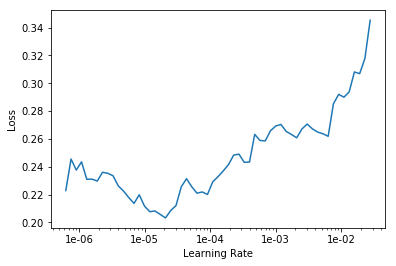

In [15]:
learn.lr_find(); learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,time
0,0.272146,0.333098,04:12


In [30]:
learn.save("Testing_mse_1_1")

In [13]:
learn.load("Testing_mse_1_1_7");

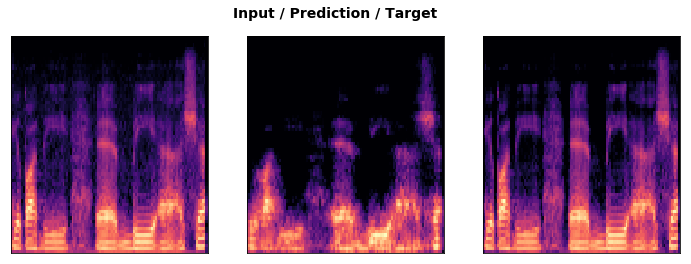

<Figure size 432x288 with 0 Axes>

In [14]:
learn.show_results(rows=1)

In [23]:
test = data.dl().dl.get(1)

0

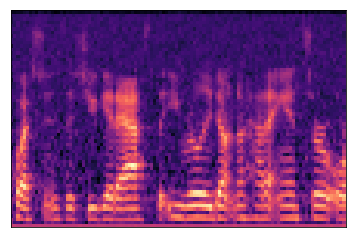

In [24]:
test.show()

In [25]:
answer = learn.predict(test.data)

0

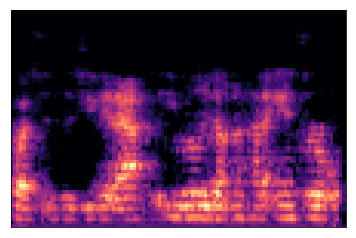

In [26]:
answer[0].show()